In [1]:
import sklearn.cluster as skCluster
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as snso
import scipy.stats as stats
import time


%matplotlib inline

<h1>Miscellaneous</h1>

In [2]:
#Make almost any discrete function into a PDF of how many times a y-value occurs in frequency throughout the function
#nump is the one-dimensional array, resolution is the how many buckets/bins, and steps is how many to skip (keep at 1 if small dataset)
def makePDF(nump, resolution, steps): 
    normalizer0 = np.max(nump) - np.min(nump)
    size = np.size(nump)
    mean = np.mean(nump)
    minimum = np.min(nump)
    bucketVolume = normalizer0 / resolution
    buckets = np.zeros((resolution + 1, 2))
    
    #Set the bucket intervals
    buckets[0, 0] = np.min(nump)
    for i in range(1, resolution + 1):
        buckets[i] = [buckets[i - 1, 0] + bucketVolume, 0]
        
    #Add to the buckets
    for i in range(0, np.size(nump), steps):
        #Bucket interval to be stored in
        index = int((nump[i] - minimum) / bucketVolume)
        buckets[index, 1] += 1
           
    #Get rid of last value, as there's no information
    buckets = np.delete(buckets, resolution, 0)
    #Normalize the y-values
    normalizer1 = np.sum(buckets, axis = 0)[1]
    for i in range(0, resolution):
        buckets[i, 1] /= normalizer1
        
        
    return buckets



#Get the probability based on the pdf
def getProbPDF(x, pdf):
    for i in range(0, np.size(pdf, axis = 0) - 1):
        if (x >= pdf[i, 0] and x < pdf[i + 1, 0]):
            return pdf[i, 1]
    return 0
        
        
        
#CDF is very intuitive and simple with the PDF
def makeCDF(nump, resolution, steps):
    pdf = makePDF(nump, resolution, steps)
    
    cdf = np.zeros((resolution, 2))
    cdf[0, 0] = pdf[0, 0]
    cdf[0, 1] = pdf[0, 1]
    
    #Integrate the PDF
    for i in range(1, resolution):
        if (cdf[i - 1, 1] == 1):
            cdf[i, 0] = pdf[i, 0]
            cdf[i, 1] = 1
        else:
            cdf[i, 0] = pdf[i, 0]
            cdf[i, 1] += cdf[i - 1, 1] + pdf[i, 1]

            
    return cdf



#Get the probability based on the CDF
def getProbCDF(x, cdf):
    for i in range(0, np.size(cdf, axis = 0) - 1):
        if (x >= cdf[i, 0] and x < cdf[i + 1, 0]):
            return cdf[i, 1]
    return 0
    
    

#CHOOSES a random value from a PDF
#Very similar to NumPy's "choice", but the probabilities don't necessarily need to add up to 1.0 (should be VERY close)
#You're going to run into situations where you're 0.000000001 away from equaling 1.0
def chooseRandomXFromPDF(pdf):
    randy = -np.inf
    while(randy == -np.inf):
        for i in range(0, np.size(pdf, axis = 0)):
            j = np.random.randint(0, np.size(pdf, axis = 0))
            randy = np.random.choice([-np.inf, pdf[j, 0]], p = [1 - pdf[j, 1], pdf[j, 1]])
            if (randy != -np.inf):
                return randy
    return 0



#Takes a 2D array, bins the first column values as x, and sums their second column values as y
def binCounts(nump2D, binCount):
    x = nump2D[:, 0]
    xMin, xMax = np.min(x), np.max(x)
    binVolume = (xMax - xMin) / binCount
    bins = np.zeros((binCount, 2))
    y = nump2D[:, 1]
    
    #Set the bin x intervals
    bins[0] = [xMin, 0]
    for i in range(1, binCount):
        bins[i, 0] = bins[i - 1, 0] + binVolume
            
    #Set the bin y counts
    for i in range(0, np.size(y)):
        if (y[i] != 0):
            currIndex = int(np.floor(x[i] / binVolume))
            bins[currIndex, 1] += y[i]       
    
    return bins



sns.set_theme()

<h1>Dataset</h1>

<h2>Import</h2>

In [3]:
#https://www.kaggle.com/datasets/whenamancodes/fraud-detection?resource=download
df = pd.read_csv("C:\\Users\\thejo\\OneDrive\\Documents\\GA Tech\\Machine Learning Intro\creditcard.csv")
pd.set_option('display.max_columns', None)
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

<h2>Analyze</h2>

In [5]:
#Fraudulent is Class = 1, and 0 otherwise
#Test for distribution of Class compared to Time feature, because we need to see if our testing and training data need to be seperated completely randomly or into chuncks of time.
#If our Time feature needs to remain chronological in order to get better predictions, another approach will need to be used
#Create a numpy array with Time and its associated Class
timeClassComparisonDF = df[['Time', 'Class']]
timeClassComparisonNP = timeClassComparisonDF.to_numpy()

#Do Class = 1 sections go together continuously for intervals to a significant degree?  Need to check before you can separate into simple time intervals.
continuousIntervalChecker = np.where(timeClassComparisonNP[:, 1] == 1)
continuousIntervalChecker = np.asarray(continuousIntervalChecker)[0]
count = 0
currContinuousFraudCluster = 0
largestContinuousFraudCluster = 0
for i in range(0, np.size(continuousIntervalChecker) - 1):
    if (continuousIntervalChecker[i] == continuousIntervalChecker[i + 1] - 1):
        count += 1  
        currContinuousFraudCluster += 1
    else: 
        if (currContinuousFraudCluster > largestContinuousFraudCluster):
            largestContinuousFraudCluster = currContinuousFraudCluster
        currContinuousFraudCluster = 0
        continue
    
print(str(100 * count / np.size(continuousIntervalChecker)) + '% of frauds are one after another.')
print(str(largestContinuousFraudCluster) + ' is the most amount of frauds one after another.')
#They definitely DO cluster immediately after each other to a significant degree.  At least 5.9% of them do out of the 492 of the 284k total
#This just means that frauds tend to happen in clusters around the same time
#This needs to be taken into consideration when we're putting everything into time intervals if we want to maintain the Time feature
#Time feature may be more trouble than it's worth still.  Need to see if the intervals between fraud events is useful.


5.894308943089431% of frauds are one after another.
5 is the most amount of frauds one after another.


LinregressResult(slope=1.2548324277467784, intercept=149.64244790780833, rvalue=0.8091088896145697, pvalue=2.4255357739210976e-107, stderr=0.04267971838861049, intercept_stderr=30.77185620335201)


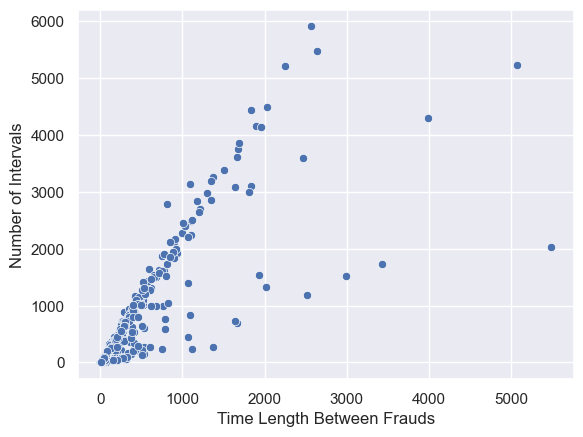

In [6]:
#Calculate the significant, unique interval sizes between Class = 0 and continuous Class = 1 events
#intervalSizes = [time length between intervals, number of intervals]
intervalSizes = np.zeros((np.size(continuousIntervalChecker), 2))
timeLength = 0
intervalCount = 0
k = 0
for i in range(0, np.size(timeClassComparisonNP, axis = 0) - 1):
    intervalCount += 1
    if (timeClassComparisonNP[i, 1] == 1 and timeClassComparisonNP[i + 1, 1] == 0):
        intervalSizes[k, 0] = timeClassComparisonNP[i, 0] - timeLength
        intervalSizes[k, 1] = intervalCount
        timeLength = timeClassComparisonNP[i + 1, 0] 
        intervalCount = 0
        k += 1
intervalSizes = intervalSizes[intervalSizes[:, 0] != 0]
plot = sns.scatterplot(x = intervalSizes[:, 0], y = intervalSizes[:, 1])
plot.set(xlabel = 'Time Length Between Frauds', ylabel = 'Number of Intervals')
print(stats.linregress(intervalSizes[:, 0], intervalSizes[:, 1]))
#About 81% of the variation in number of intervals can be explained by time length between frauds.  
#An r^2 of .65 is only moderately correlated, so the Time feature may be useful in predicting fraud and may be worth the effort to preserve.
#Time is the only feature from this dataset that is this complicated, as chronological order must be somewhat maintained when separating the dataset into testing/training.


In [7]:
#Get the distribution relationships between each feature compared to the Class feature to easily analyze the data and make sure none of the relationships are too uniform/random
distributionsOfClass = pd.DataFrame(data = (binCounts(((df[['Time', 'Class']]).to_numpy()), 20))[:, 1],
                                    columns = ['Time'])

for column in df:
    if (column != 'Time' and column != 'Class'):
        nump = df[[column, 'Class']]
        nump = nump.to_numpy()
        g = binCounts(nump, 400)
        new = pd.DataFrame(data = g[:, 1],
                           columns = [column])
        distributionsOfClass = distributionsOfClass.join(new)
        
distributionsOfClass.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,20.0,8.0,9.0,3.0,1.0,21.0,15.0,27.0,43.0,6.0,2.0,3.0,3.0,5.0,2.0,6.0,4.0,1.0,0.0,3.0,53.0,26.0,9.0,52.0,9.0,17.0,6.0,54.0,75.0,314.0
1,22.0,11.0,10.0,2.0,1.0,28.0,10.0,15.0,31.0,4.0,5.0,0.0,1.0,5.0,3.0,7.0,5.0,5.0,4.0,8.0,72.0,29.0,9.0,41.0,7.0,15.0,3.0,27.0,66.0,72.0
2,19.0,11.0,11.0,4.0,3.0,25.0,12.0,12.0,41.0,5.0,6.0,0.0,3.0,5.0,1.0,2.0,3.0,3.0,6.0,5.0,53.0,37.0,15.0,26.0,3.0,17.0,5.0,34.0,64.0,20.0
3,29.0,7.0,12.0,0.0,2.0,17.0,8.0,11.0,25.0,2.0,3.0,4.0,1.0,6.0,2.0,2.0,3.0,5.0,7.0,2.0,26.0,47.0,16.0,20.0,4.0,16.0,8.0,53.0,56.0,15.0
4,56.0,5.0,27.0,5.0,2.0,14.0,5.0,7.0,26.0,2.0,4.0,1.0,3.0,6.0,1.0,10.0,4.0,1.0,0.0,6.0,26.0,32.0,14.0,9.0,3.0,10.0,9.0,42.0,24.0,17.0


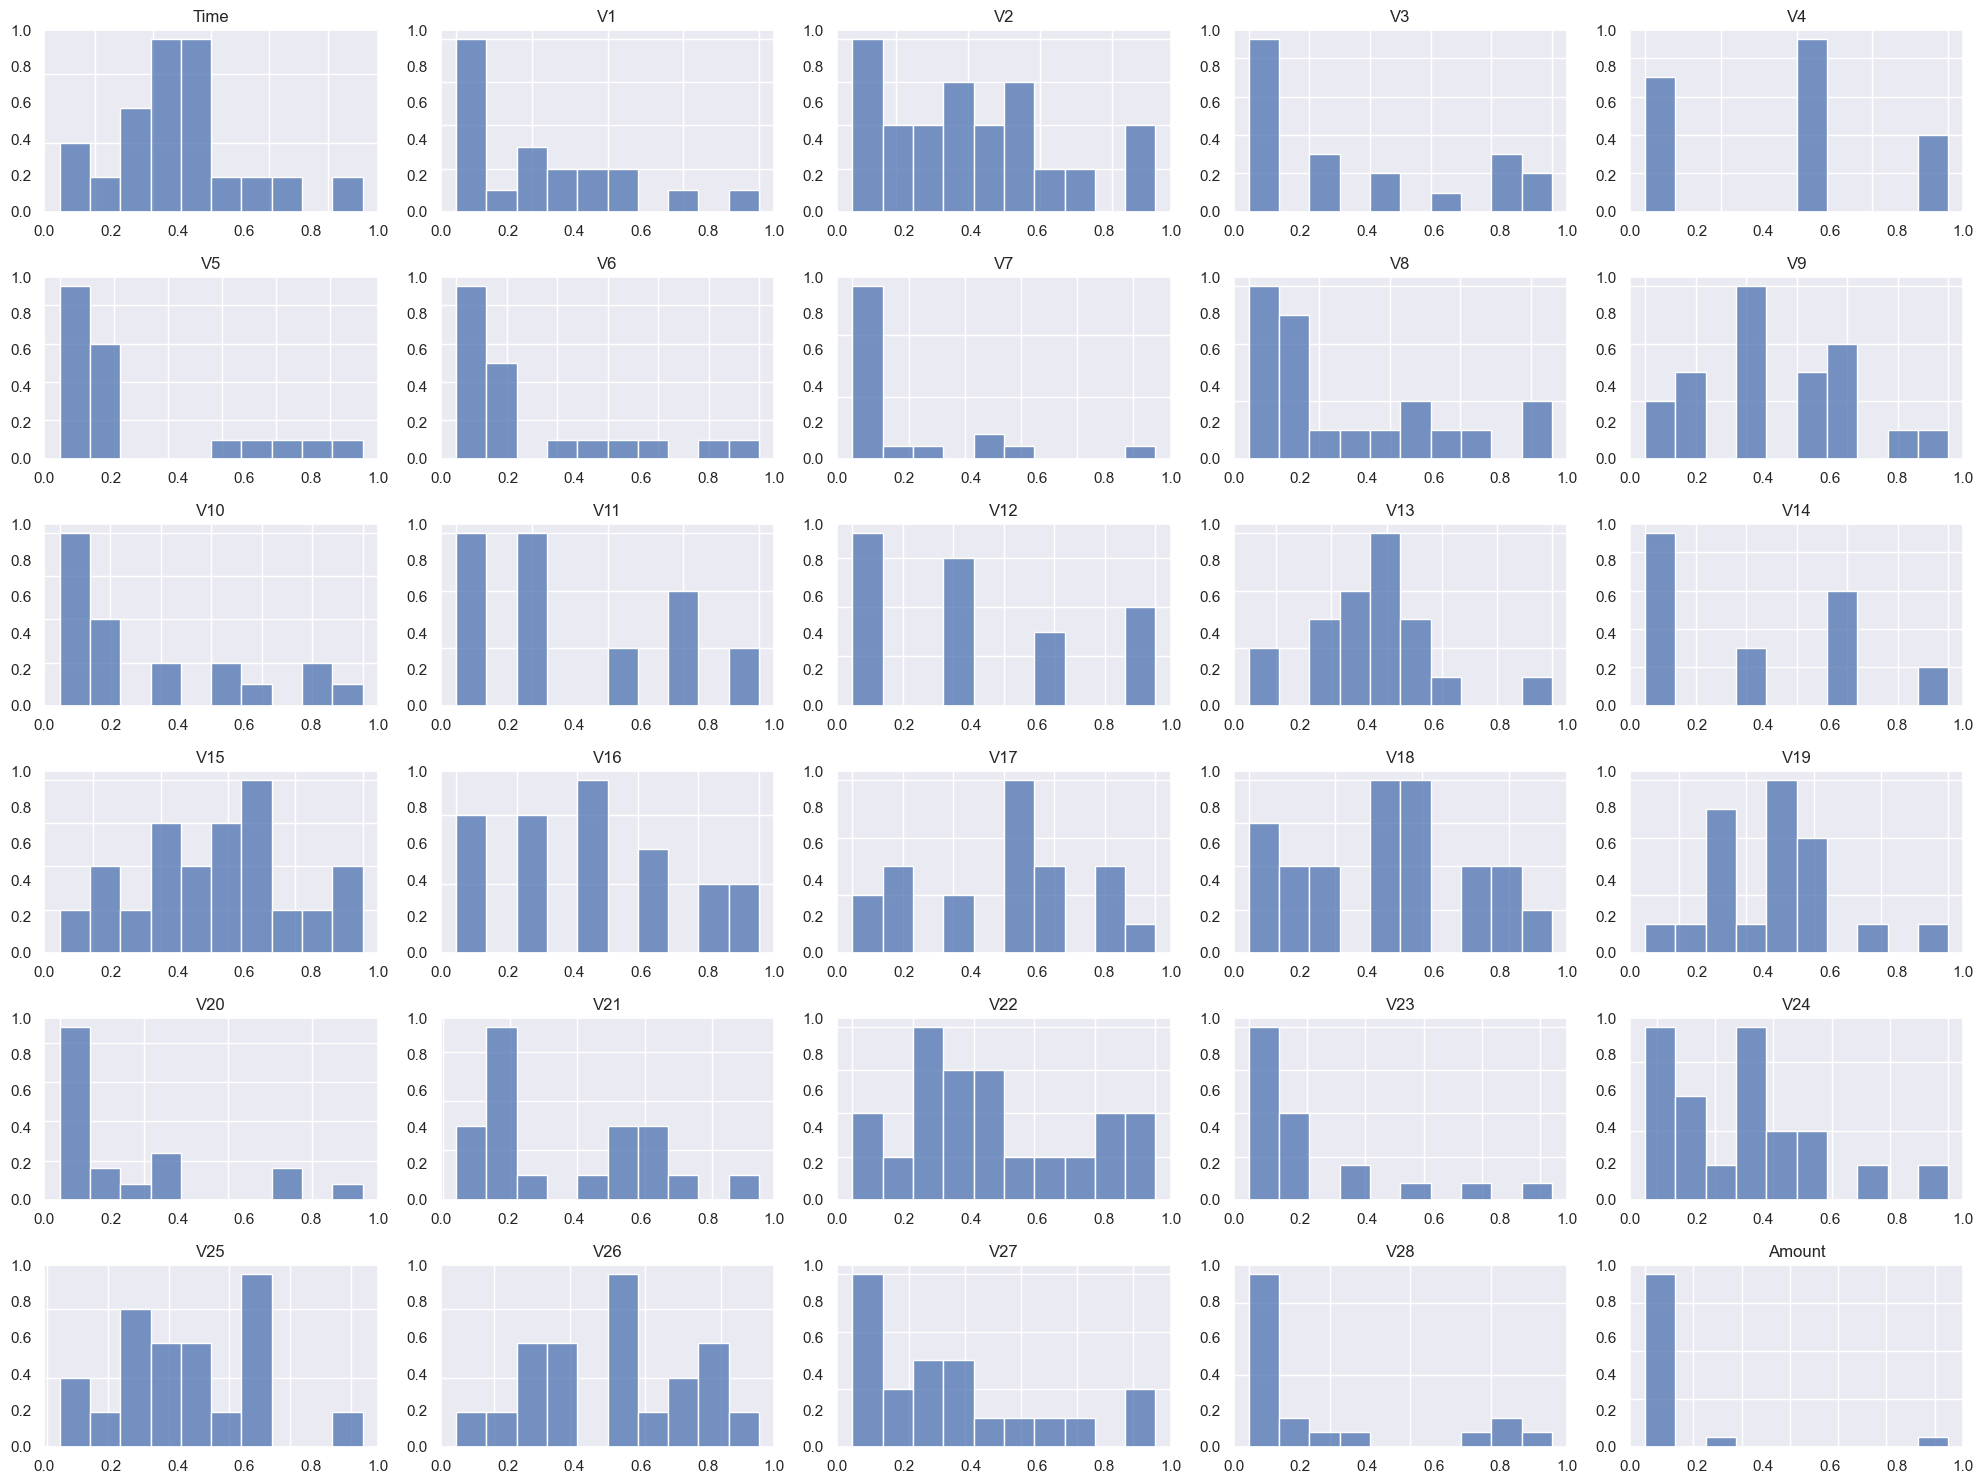

In [8]:
#Fraud Count to Feature Metric Distribution with Linear r^2 Correlation

fig, axes = plt.subplots(6, 5)
fig.set_figheight(15)
fig.set_figwidth(20)

i = 0
for column in distributionsOfClass:
    #Get its LINEAR r^2 correlation to add as annotation
    
    fig.add_subplot(6, 5, i + 1)
    h = sns.histplot(data = distributionsOfClass, x = column, bins = 10)
    h.set(xlabel = None, xticklabels = [], ylabel = None, yticklabels = [], title = column)
    i += 1
fig.tight_layout()



<h3>Discussion</h3>
<p>Just from eyeballing these relationships, none of the features appear to be particularly uniform (i.e random) or redundant (arguably V5, V6, and V23).  These features have likely been well been well-chosen from experience and research of analyzing credit card fraud.  They also appear to tend to be to be left-side heavy.  This may be informative 

<h2>Separate Test and Training Data</h2>

<h1>Dimensionality Reduction</h1>

<h2>Principal Component Analysis</h2>

<h1>Unsupervised Learning</h1>

<h2>K-Means Clustering</h2>

<h2>Expectation Maximization</h2>